<a href="https://colab.research.google.com/github/ryuuunothuman/PCVK_Ganjil_2024/blob/master/Week12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tugas Praktikum

Lakukan Face Detection untuk image object lain yang tersedia pada (/images/facedet).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import library yang dibutuhkan
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import PIL
import io
import html
import time
from base64 import b64decode, b64encode
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js

In [8]:
def detect_face_alternative(image_path, xml_classifier='/content/drive/MyDrive/images/images/haarcascades/haarcascade_frontalface_alt.xml'):
    # Load the pre-trained face classifier
    face_cascade = cv.CascadeClassifier(xml_classifier)

    # Read the image and make a copy
    original_image = cv.imread(image_path)
    processed_image = original_image.copy()

    # Detect faces in the image
    detected_faces = face_cascade.detectMultiScale(original_image)

    # Draw rectangles around the detected faces
    for (x, y, w, h) in detected_faces:
        cv.rectangle(processed_image, (x, y), (x + w, y + h), (0, 255, 0), 3)

    # Display the images using matplotlib
    plt.figure(figsize=(10, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(cv.cvtColor(original_image, cv.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv.cvtColor(processed_image, cv.COLOR_BGR2RGB))
    plt.axis("off")

    plt.show()

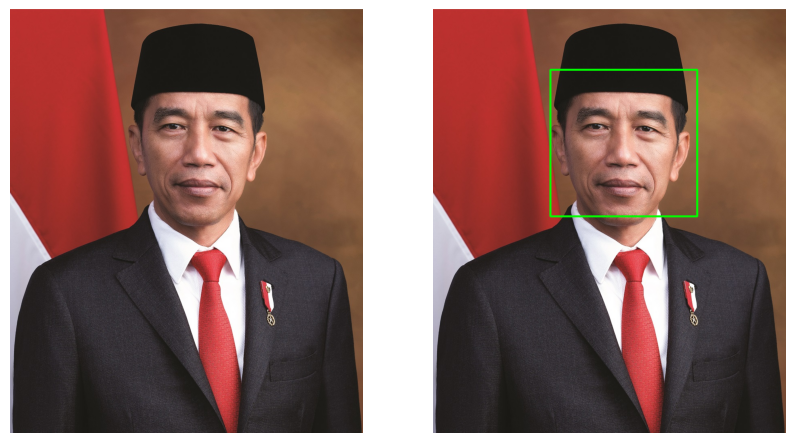

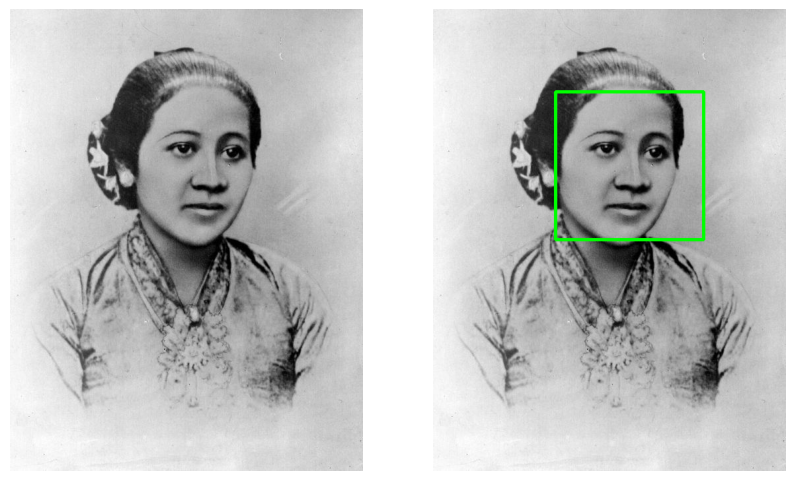

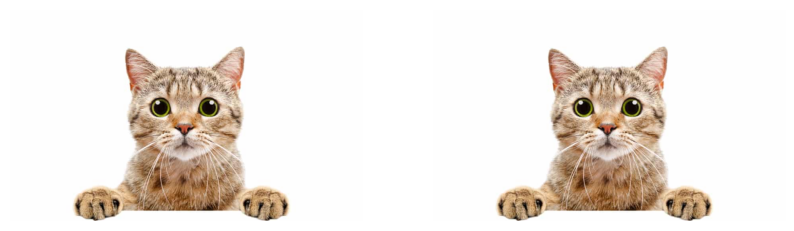

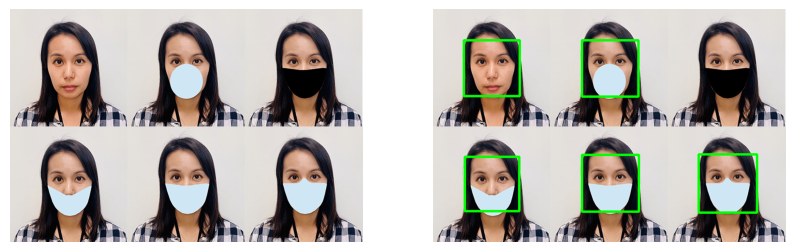

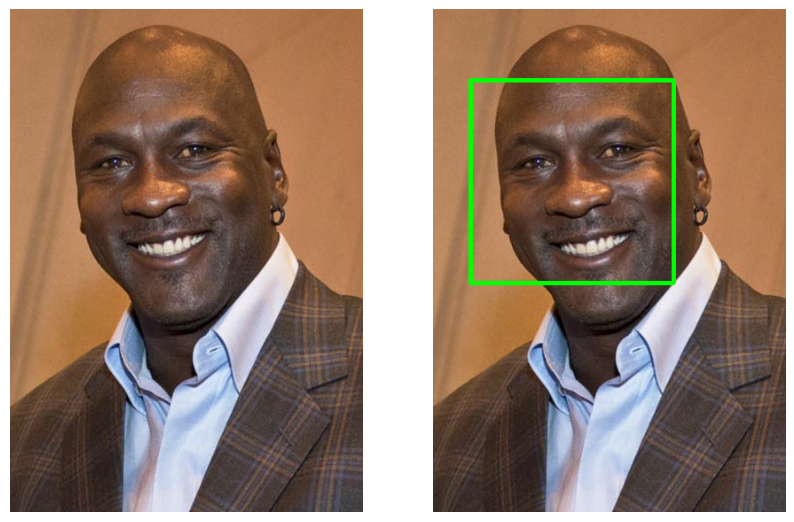

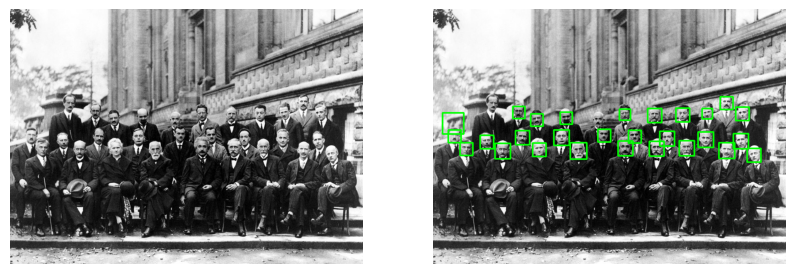

In [9]:
# Jokowi
detect_face_alternative('/content/drive/MyDrive/images/images/facedet/jokowi.jpg')
# Kartini
detect_face_alternative('/content/drive/MyDrive/images/images/facedet/kartini.jpg')
# Kucing
detect_face_alternative('/content/drive/MyDrive/images/images/facedet/kucing.jpg')
# Mask
detect_face_alternative('/content/drive/MyDrive/images/images/facedet/mask.png')
# Mjordan
detect_face_alternative('/content/drive/MyDrive/images/images/facedet/mjordan.jpg')
# Solvayconf
detect_face_alternative('/content/drive/MyDrive/images/images/facedet/solvayconf.jpg')

Pada Soal No.2. wajah kucing tidak bisa dideteksi dengan baik. Lakukan deteksi wajah
kucing hingga muncul rectangle pada bagian wajahnya. Petunjuk pada soal ini,
perhatikan pretrained features yang telah disediakan OpenCV. Gunakan xml yang ada
jika memang telah disediakan. Jika belum ada, coba cari dengan searching melalui
search engines.

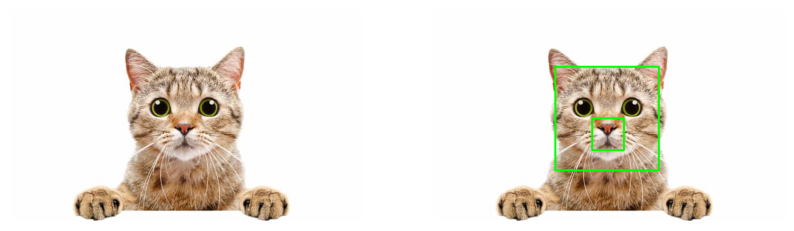

In [10]:
# Kucing
detect_face_alternative('/content/drive/MyDrive/images/images/facedet/kucing.jpg','/content/drive/MyDrive/images/images/haarcascades/haarcascade_frontalcatface.xml')

Cobakan juga untuk eyes detection.

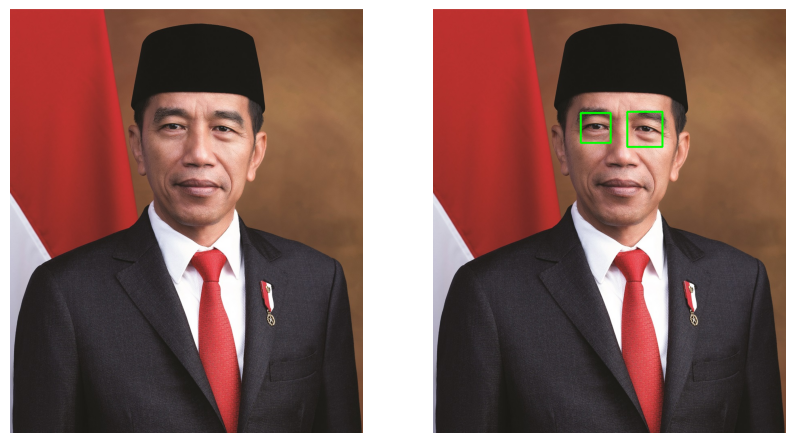

In [11]:
# Eyes Detection
detect_face_alternative('/content/drive/MyDrive/images/images/facedet/jokowi.jpg','/content/drive/MyDrive/images/images/haarcascades/haarcascade_eye.xml')

Lakukan Face Tracking menggunakan Google Colab.

In [12]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

# initialize the Haar Cascade face detection model
face_cascade = cv.CascadeClassifier(cv.samples.findFile(cv.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [13]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "Status:";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '' +
          'When finished, click here or on the video to stop this demo';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [15]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      bbox_array = cv.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

Lakukan Blurring pada bagian wajah yang terdeteksi.

In [19]:
def blur_detect_face_light(img_path, classifier='/content/drive/MyDrive/images/images/haarcascades/haarcascade_frontalface_alt.xml'):
    # Load the pre-trained face classifier
    face_cascade = cv.CascadeClassifier(classifier)

    # Read the image and make a copy
    img = cv.imread(img_path)
    img_copy = img.copy()

    # Convert the image to grayscale for face detection
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)

    # Apply a lighter Gaussian blur to the detected face regions
    for (x, y, w, h) in faces:
        face_roi = img_copy[y:y+h, x:x+w]
        # Using a lighter blur (15x15 kernel size)
        blurred_face = cv.GaussianBlur(face_roi, (15, 15), 10)
        img_copy[y:y+h, x:x+w] = blurred_face

    # Display the original and blurred images
    plt.figure(figsize=(10, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.title('Original')
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv.cvtColor(img_copy, cv.COLOR_BGR2RGB))
    plt.title('Faces Blurred (Light)')
    plt.axis("off")

    plt.show()

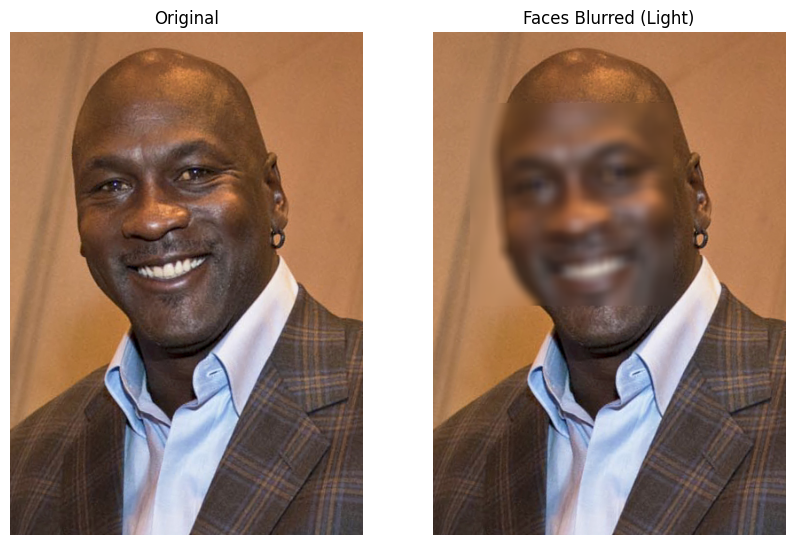

In [20]:
blur_detect_face_light('/content/drive/MyDrive/images/images/facedet/mjordan.jpg')

Lakukan segmentasi karakter pada KTP

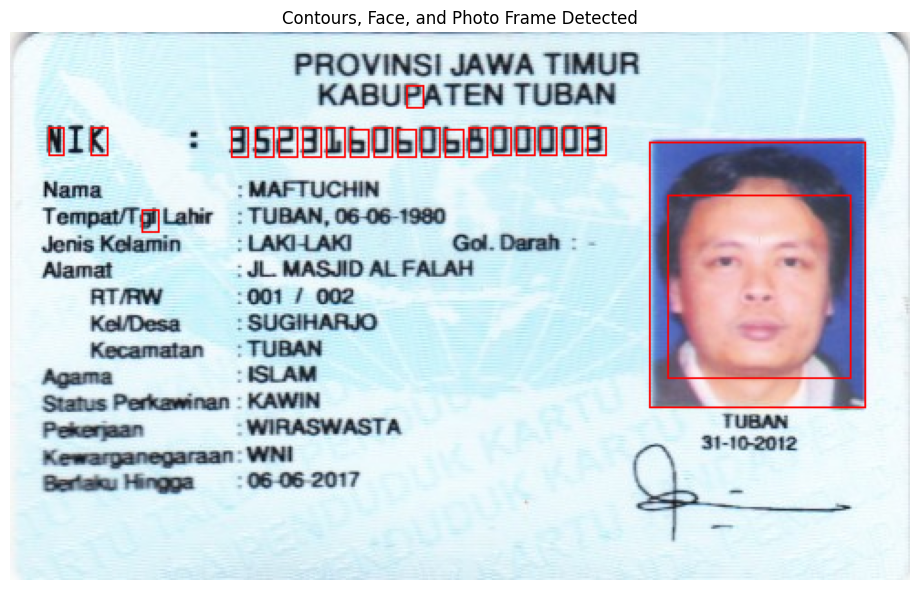

In [54]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load image
ktp = cv.imread('/content/drive/MyDrive/images/images/KTP_More/KTP_More/ktp3.png')

# Menerapkan Gaussian Blur
blurred = cv.GaussianBlur(ktp.copy(), (5, 5), 0.5)

# Ubah ke grayscale
gray = cv.cvtColor(blurred, cv.COLOR_BGR2GRAY)

# Thresholding dengan Otsu
ret, bw = cv.threshold(gray.copy(), 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
_, binary_image = cv.threshold(bw, 128, 255, cv.THRESH_BINARY_INV)

# Operasi morfologi
kernel = np.ones((2, 2), np.uint8)
morph_image = cv.morphologyEx(binary_image, cv.MORPH_CLOSE, kernel, iterations=1)

# Temukan kontur
contours, _ = cv.findContours(morph_image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Filter kontur untuk karakter NIK
min_area = 55
max_area = 130
aspect_ratio_range = (0.01, 0.9)

# Gambar asli untuk visualisasi kontur
output_image = ktp.copy()

for contour in contours:
    x, y, w, h = cv.boundingRect(contour)
    area = cv.contourArea(contour)
    aspect_ratio = float(w) / h

    if min_area <= area <= max_area and aspect_ratio_range[0] <= aspect_ratio <= aspect_ratio_range[1]:
        cv.rectangle(output_image, (x, y), (x + w, y + h), (0, 0, 255), 1)

# Tambahkan deteksi wajah
face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

for (x, y, w, h) in faces:
    cv.rectangle(output_image, (x, y), (x + w, y + h), (0, 0, 255), 1)

# Tambahkan bingkai merah di sekitar area foto KTP
# Asumsi: Area foto KTP berada di sekitar bagian atas gambar (sesuai dengan struktur KTP umumnya)
photo_area_x, photo_area_y, photo_area_w, photo_area_h = 350, 60, 118, 145  # Ganti dengan koordinat sesuai kebutuhan
cv.rectangle(output_image, (photo_area_x, photo_area_y),
             (photo_area_x + photo_area_w, photo_area_y + photo_area_h), (0, 0, 255), 1)

# Visualisasi hasil
plt.figure(figsize=(10, 6))
plt.imshow(cv.cvtColor(output_image, cv.COLOR_BGR2RGB))
plt.title("Contours, Face, and Photo Frame Detected")
plt.axis("off")
plt.tight_layout()
plt.show()

Lakukan cropping pada bagian NIK saja sehingga muncul hasil sebagai berikut

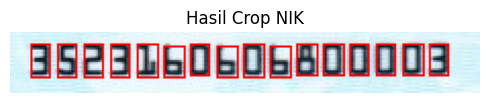

In [57]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Baca gambar KTP
ktp_image = cv.imread('/content/drive/MyDrive/images/images/KTP_More/KTP_More/ktp3.png')

# Crop area NIK
x_start = 110
y_start = 45
width = 230
height = 30
nik_area = ktp_image[y_start:y_start + height, x_start:x_start + width]

# Terapkan Gaussian Blur
blurred_nik_area = cv.GaussianBlur(nik_area, (5, 5), 0.5)

# Konversi ke grayscale
grayscale_nik = cv.cvtColor(blurred_nik_area, cv.COLOR_BGR2GRAY)

# Thresholding menggunakan Otsu
_, binary_thresh = cv.threshold(grayscale_nik, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
_, binary_inv = cv.threshold(binary_thresh, 80, 255, cv.THRESH_BINARY_INV)

# Operasi morfologi untuk memisahkan karakter
morph_kernel = np.ones((3, 3), np.uint8)
morphed_image = cv.morphologyEx(binary_inv, cv.MORPH_CLOSE, morph_kernel, iterations=1)

# Cari kontur
contours, _ = cv.findContours(morphed_image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Batasan untuk ukuran dan rasio aspek kontur karakter NIK
min_area_threshold = 40
max_area_threshold = 170
aspect_ratio_min, aspect_ratio_max = 0.4, 1

# Salin gambar untuk menggambar kontur
visualization_image = nik_area.copy()

# Loop melalui setiap kontur dan gambar bounding box
for contour in contours:
    x, y, w, h = cv.boundingRect(contour)
    area = cv.contourArea(contour)
    aspect_ratio = float(w) / h

    if min_area_threshold <= area <= max_area_threshold and aspect_ratio_min <= aspect_ratio <= aspect_ratio_max:
        cv.rectangle(visualization_image, (x, y), (x + w, y + h), (0, 0, 255), 1)

# Tampilkan hasil
plt.figure(figsize=(5, 6))
plt.imshow(cv.cvtColor(visualization_image, cv.COLOR_BGR2RGB))
plt.title("Hasil Crop NIK")
plt.axis("off")
plt.tight_layout()
plt.show()

Kita akan menggunakan Deep Learning untuk melakukan pengenalan karakter Sebelum melakukan training data, terlebih dahulu di siapkan data yang akan dilakukan training yaitu data image nomor angka 0-9. Untuk membuat data tersebut bisa gunakan image editor untuk dilakukan croping satu persatu. Kemudian selanjutnya gunakan source code di bawah ini untuk proses persiapan untuk training.

In [58]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(28,28,1)),
  tf.keras.layers.ZeroPadding2D(padding=(2, 2)),
  tf.keras.layers.Conv2D(16, (5, 5), strides=(1, 1), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1),activation='relu'),
  tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1),activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), activation='relu'),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [59]:
model.fit(x_train, y_train, epochs=10)
model.evaluate(x_test, y_test)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 69s 35ms/step - accuracy: 0.8822 - loss: 0.3630
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 78s 33ms/step - accuracy: 0.9831 - loss: 0.0541
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 33ms/step - accuracy: 0.9885 - loss: 0.0359
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 83s 34ms/step - accuracy: 0.9909 - loss: 0.0295
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 64s 34ms/step - accuracy: 0.9924 - loss: 0.0250
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 63s 34ms/step - accuracy: 0.9936 - loss: 0.0189
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 63s 34ms/step - accuracy: 0.9943 - loss: 0.0167
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 33ms/step - accuracy: 0.9951 - loss: 0.0156
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 34ms/step - accuracy: 0.9954 - loss: 0.0145
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 63s 33ms/step - accuracy: 0.9959 - loss: 0.0142
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9861 - loss: 0.0477


[0.03611942008137703, 0.9896000027656555]

In [60]:
model.save('model.keras')

# Tugas

Silakan melakukan pengenalan NIK pada e-KTP yang terdapat pada tugas modul 11!

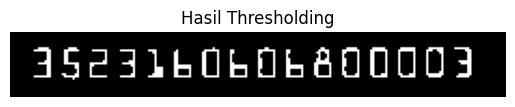

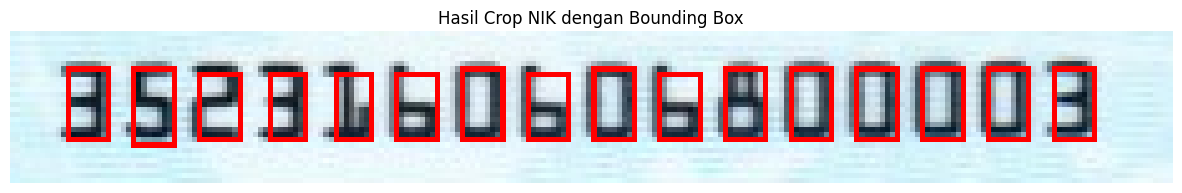

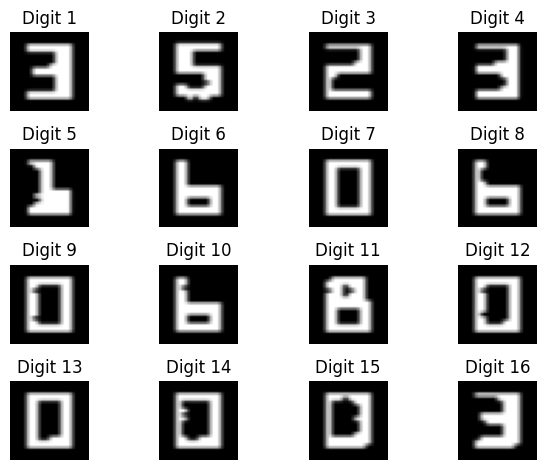

Jumlah digit yang terdeteksi: 16


In [63]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Baca gambar KTP
ktp_image = cv.imread('/content/drive/MyDrive/images/images/KTP_More/KTP_More/ktp3.png')

# Tentukan area NIK untuk dipotong
crop_x, crop_y, crop_width, crop_height = 110, 45, 230, 30
nik_area = ktp_image[crop_y:crop_y + crop_height, crop_x:crop_x + crop_width]

# Terapkan Gaussian Blur untuk mengurangi noise
blurred_image = cv.GaussianBlur(nik_area, (5, 5), 0.3)

# Konversi gambar ke grayscale
grayscale_image = cv.cvtColor(blurred_image, cv.COLOR_BGR2GRAY)

# Lakukan thresholding menggunakan Otsu
_, binary_thresh = cv.threshold(grayscale_image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
_, binary_inverted = cv.threshold(binary_thresh, 100, 255, cv.THRESH_BINARY_INV)

# Lakukan operasi morfologi untuk memperbaiki hasil thresholding
morph_kernel = np.ones((2, 2), np.uint8)
morph_image = cv.erode(binary_inverted, morph_kernel, iterations=1)

# Tampilkan hasil thresholding
plt.imshow(morph_image, cmap='gray')
plt.title("Hasil Thresholding")
plt.axis("off")
plt.show()

# Cari kontur pada gambar yang telah diproses
contours, _ = cv.findContours(morph_image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Batasan ukuran dan rasio aspek untuk karakter NIK
min_area, max_area = 1, 100
aspect_ratio_min, aspect_ratio_max = 0.01, 1.4

# Salin gambar untuk menggambar bounding box
visualized_image = nik_area.copy()

# List untuk menyimpan digit-digit NIK yang terdeteksi
nik_characters = []

# Kumpulkan bounding box dan sortir dari kiri ke kanan
bounding_boxes = [
    (x, y, w, h, contour) for contour in contours
    for x, y, w, h in [cv.boundingRect(contour)]
    if min_area <= cv.contourArea(contour) <= max_area and aspect_ratio_min <= (float(w) / h) <= aspect_ratio_max
]
bounding_boxes.sort(key=lambda box: box[0])  # Urutkan berdasarkan koordinat x

# Ekstrak setiap digit dan visualisasikan
for x, y, w, h, contour in bounding_boxes:
    # Crop digit dari gambar biner
    digit_image = binary_inverted[y:y+h, x:x+w]

    # Tambahkan padding (opsional) untuk setiap digit
    padding = 3
    digit_image = cv.copyMakeBorder(digit_image, padding, padding, padding, padding, cv.BORDER_CONSTANT, value=0)

    # Resize digit ke ukuran 28x28
    digit_image = cv.resize(digit_image, (28, 28))
    nik_characters.append(digit_image)

    # Gambar bounding box pada area NIK
    cv.rectangle(visualized_image, (x, y), (x + w, y + h), (0, 0, 255), 1)

# Tampilkan gambar dengan bounding box
plt.figure(figsize=(15, 6))
plt.imshow(cv.cvtColor(visualized_image, cv.COLOR_BGR2RGB))
plt.title("Hasil Crop NIK dengan Bounding Box")
plt.axis("off")
plt.show()

# Tampilkan digit-digit yang telah diekstrak
for i, digit in enumerate(nik_characters):
    plt.subplot(4, 4, i + 1)
    plt.imshow(digit, cmap='gray')
    plt.title(f"Digit {i + 1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Cetak jumlah digit yang terdeteksi
print(f"Jumlah digit yang terdeteksi: {len(nik_characters)}")

In [64]:
# Menggunakan model yang sudah ditrain untuk mendeteksi NIK
# Prediksi setiap digit
predictions = []
for digit in nik_characters:
    # Tambahkan dimensi batch
    digit_batch = np.expand_dims(digit, axis=0)
    # Prediksi
    pred = model.predict(digit_batch)
    # Ambil kelas dengan probabilitas tertinggi
    predicted_class = np.argmax(pred[0])
    predictions.append(predicted_class)

print("NIK terdeteksi:", "".join(map(str, predictions)))
print("NIK Asli      : 3523160606800003")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
NIK terdeteksi: 3523360606800023
NIK Asli      : 3523160606800003
